In [457]:
import os
import datetime
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import boto3

import sagemaker
from sagemaker.amazon.common import RecordSerializer
from sagemaker import RandomCutForest
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

import matplotlib.pyplot as plt

In [395]:
client = boto3.client('timestream-query')
%matplotlib inline

In [445]:
interval = "1m"
period = '2d'

In [446]:
response = client.query(
    QueryString='SELECT BIN(time, ' + interval +') AS BINNED_TIMESTAMP, ROUND(AVG(measure_value::double), 2) AS TEMPERATURE, ROOM as ROOM FROM "TemperatureHistory"."TemperatureHistory" WHERE measure_name = \'TEMPERATURE\' AND ROOM = \'office\' AND time > ago(' + period + ') GROUP BY measure_name, BIN(time, ' + interval + '), ROOM ORDER BY BINNED_TIMESTAMP ASC'
)

In [447]:
time = []
temperature = []

for x in response['Rows']:
    raw_date = x["Data"][0]["ScalarValue"]
    raw_temperature = x["Data"][1]["ScalarValue"]
    formatted_date = datetime.datetime.strptime(raw_date, "%Y-%m-%d %H:%M:%S.%f000")

    temperature.append(raw_temperature)
    time.append(str(formatted_date.day) + "/" + str(formatted_date.month) + " " + str(formatted_date.hour) + ":" + str(formatted_date.minute))

In [448]:
print("Average temperature over this period: " + str(sum([float(i) for i in temperature]) / len(temperature)) + "oC")
print("Seen data points: " + str(len(temperature)))

Average temperature over this period: 20.207922889892327oC
Seen data points: 2879


In [449]:
float_temperatures = [float(temp) for temp in temperature]

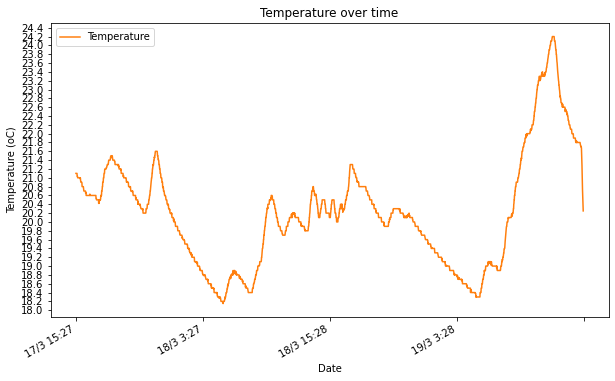

In [450]:
def plot_matplotlib(time, temp):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.yaxis.set_major_locator(plticker.MultipleLocator(0.2))
    ax.xaxis.set_major_locator(plticker.MultipleLocator(720))

    fig.autofmt_xdate()

    ax.plot(time, temp, color='tab:orange', label='Temperature')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (oC)')
    ax.set_title('Temperature over time')
    ax.legend(loc='upper left');
    
plot_matplotlib(time, float_temperatures)

In [451]:
temperature_time_series = zip(time, float_temperatures)

In [452]:
temperature_dataframe = pd.DataFrame(data=temperature_time_series)

<AxesSubplot:title={'center':'Temperature over time'}>

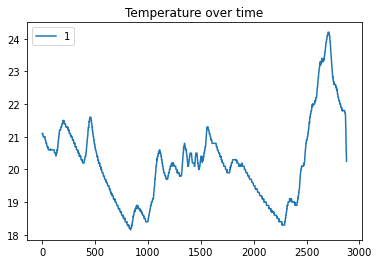

In [453]:
temperature_dataframe.plot(title="Temperature over time")

In [454]:
session = sagemaker.Session()

In [455]:
rcf = RandomCutForest(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location="s3://xyz.jacobclark.sagemaker/sagemaker/randomcutforest",
    output_path="s3://xyz.jacobclark.sagemaker/sagemaker/randomcutforest/out",
    num_samples_per_tree=512,
    num_trees=50,
)

rcf.fit(rcf.record_set(temperature_dataframe[1].to_numpy().reshape(-1, 1)))

print(f"Training job name: {rcf.latest_training_job.job_name}")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-03-19 15:27:18 Starting - Starting the training job...
2021-03-19 15:27:41 Starting - Launching requested ML instancesProfilerReport-1616167637: InProgress
......
2021-03-19 15:28:41 Starting - Preparing the instances for training......
2021-03-19 15:29:41 Downloading - Downloading input data...
2021-03-19 15:30:09 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[03/19/2021 15:30:33 INFO 139661851309888] Reading default configuration fro

In [456]:
rcf_inference = rcf.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge"
)

print(f"Endpoint name: {rcf_inference.endpoint}")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-03-19-15-30-59-822


In [458]:
rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [459]:
temperature_data_numpy = temperature_dataframe[1].to_numpy().reshape(-1, 1)

In [460]:
results = rcf_inference.predict(temperature_data_numpy)

In [461]:
scores = [datum["score"] for datum in results["scores"]]

In [466]:
temperature_dataframe["score"] = pd.Series(scores, index=temperature_dataframe.index)

score_mean = temperature_dataframe.score.mean()
score_std = temperature_dataframe.score.std()

std_deviations_to_cutoff_by = 2
score_cutoff = score_mean + std_deviations_to_cutoff_by * score_std

anomalies = temperature_dataframe[temperature_dataframe['score'] > score_cutoff]

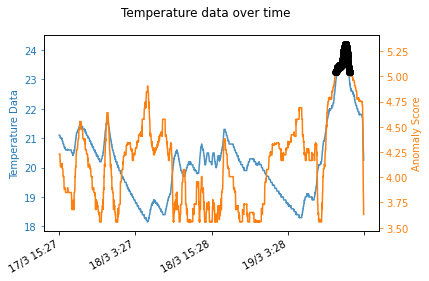

In [467]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(temperature_dataframe[0], temperature_dataframe[1], alpha=0.8)
ax2.plot(temperature_dataframe['score'], color='C1')
ax2.plot(anomalies.index, anomalies.score, 'ko')

ax1.set_ylabel('Temperature Data', color='C0')
ax1.tick_params('y', colors='C0')

ax1.xaxis.set_major_locator(plticker.MultipleLocator(720))

ax2.set_ylabel('Anomaly Score', color='C1')
ax2.tick_params('y', colors='C1')

fig.autofmt_xdate()
fig.suptitle('Temperature data over time')
plt.show()

In [468]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
